# AI Community Innopolis #1, Fall 2018
### Contest 1: Predict which items the customer will buy

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

np.random.seed(42)
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Let's read the data.

In [2]:
train_data = pd.read_csv('data/train_data.csv',
                         parse_dates=['rec_date'])
test_data = pd.read_csv('data/test_data.csv',
                        parse_dates=['rec_date'])
recipts_history = pd.read_csv('data/receipts_history.csv',
                              parse_dates=['rec_date'])
categories = pd.read_csv('data/categories.csv')

In [3]:
train_data.head(2)

,user_id,shop_geo_lat,shop_geo_lon,rec_date,cat_0,cat_1,cat_2,cat_3,cat_4,cat_5,...,cat_15,cat_16,cat_17,cat_18,cat_19,cat_20,cat_21,cat_22,cat_23,cat_24
0,21303,50.576368,36.582109,2018-09-06 11:49:00,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,18137,59.414255,56.854880,2018-07-31 13:13:00,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [4]:
train_data.size

86797

In [5]:
test_data.head(3)

,user_id,shop_geo_lat,shop_geo_lon,rec_date
0,21303,50.627550,36.568998,2018-09-06 17:01:00
1,22638,59.724899,30.406318,2018-09-05 21:07:00
2,21309,58.977102,43.134100,2018-08-16 12:59:00


In [6]:
test_data.size

6060

In [7]:
recipts_history.head(3)

,user_id,rec_id,shop_geo_lat,shop_geo_lon,rec_date,rec_total,cat_0,cat_1,cat_2,cat_3,...,cat_15,cat_16,cat_17,cat_18,cat_19,cat_20,cat_21,cat_22,cat_23,cat_24
0,21303,32606,50.560819,36.569266,2018-08-21 11:24:00,2399000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21303,32605,50.627550,36.568998,2018-08-22 17:11:00,15700,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,21303,32603,50.555208,36.561561,2018-08-23 09:02:00,100000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
target_column_names = list(set(train_data.columns) - set(test_data.columns))

X_train = train_data.drop(columns=target_column_names)
X_test = test_data

y_train = train_data[target_column_names]

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                      test_size=0.3,
                                                      random_state=42)

In [9]:
X_train.head(3)

,user_id,shop_geo_lat,shop_geo_lon,rec_date
1268,5189,50.545123,136.976384,2018-02-28 12:16:00
2490,22941,53.538441,49.337778,2018-08-25 14:32:00
2111,21051,55.595722,37.208109,2018-08-24 19:21:00


---
#### EDA
Let's perform an exploratory data analysis for the columns `rec_date`, `shop_geo_lat` and `shop_geo_lon`.

In [10]:
X = pd.concat([X_train, X_valid, X_test], axis='rows')

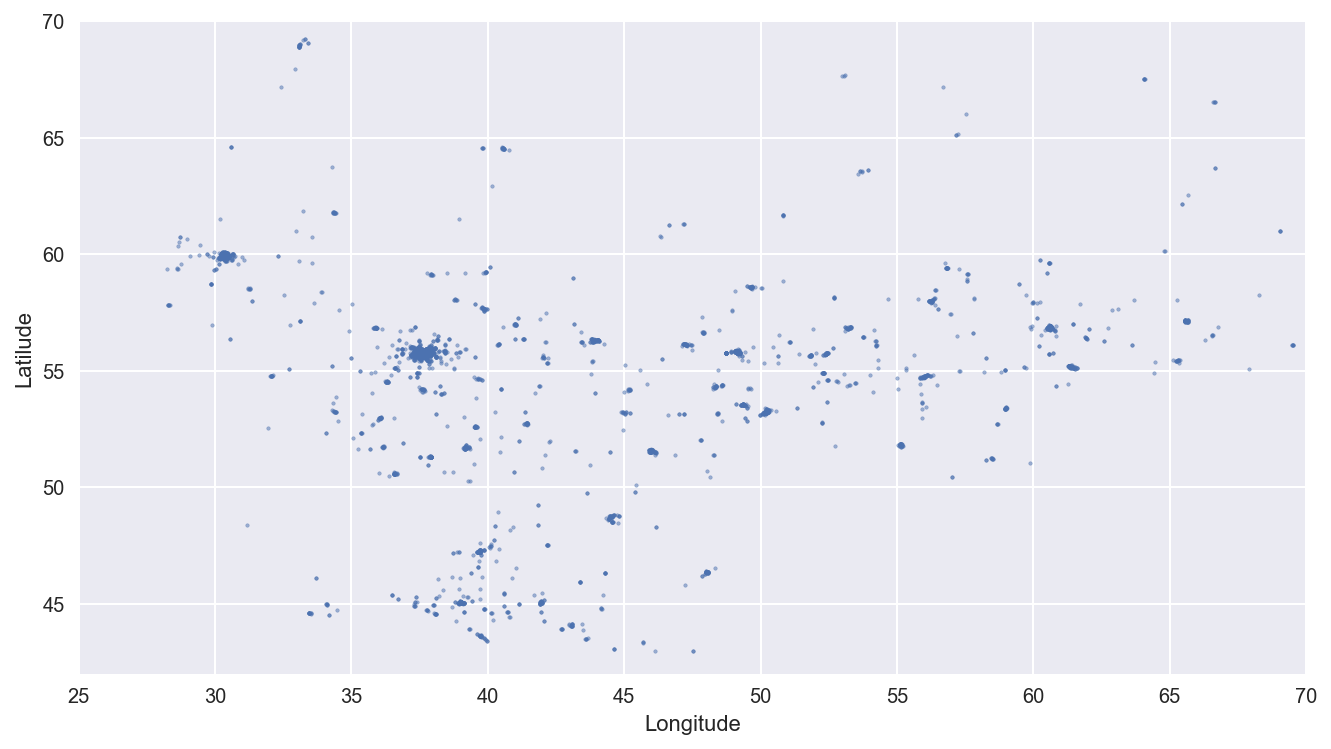

In [11]:
plt.figure(figsize=(11, 6))
plt.xlim([25, 70])
plt.xlabel('Longitude')
plt.ylabel('Latilude')
plt.ylim([42, 70])
plt.scatter(X.shop_geo_lon, X.shop_geo_lat, s=3, alpha=0.5);

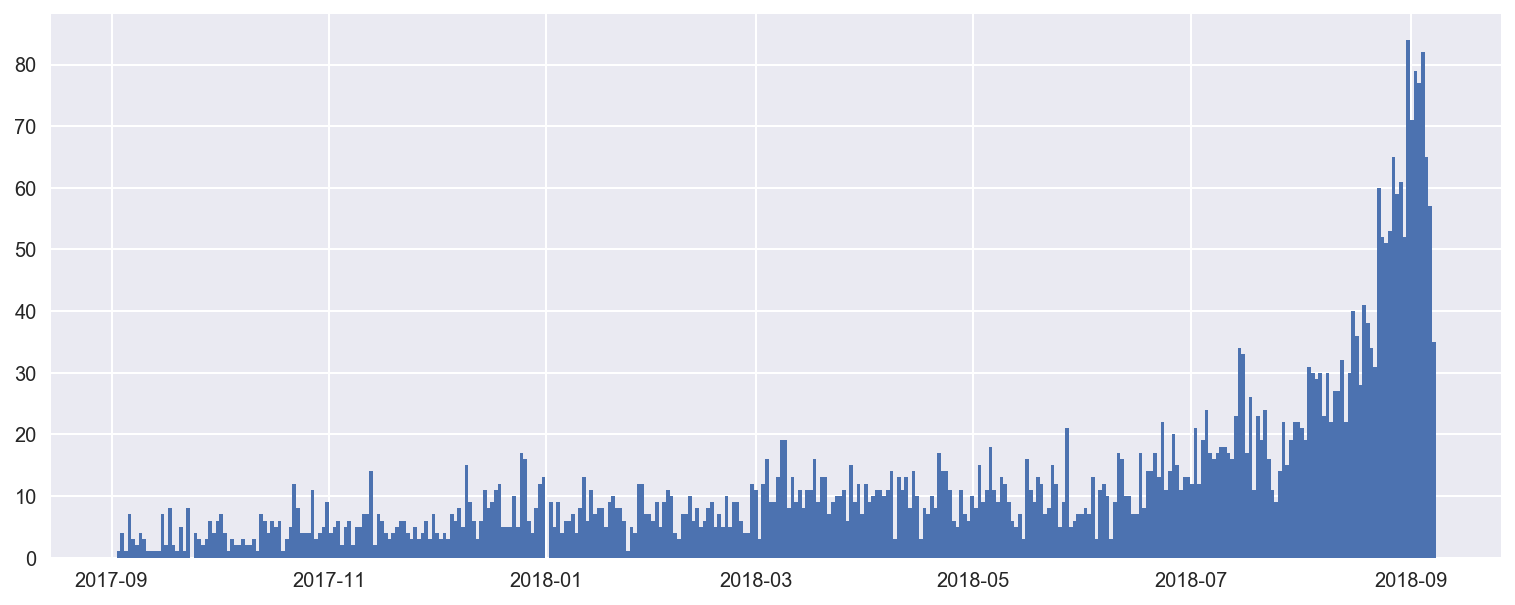

In [12]:
rec_dates = X.query('rec_date > "2017-09"').rec_date

rec_dates.hist(bins=len(np.unique(list(zip(rec_dates.dt.month,
                                           rec_dates.dt.day)), axis=0)),
               figsize=(13, 5));

---
#### Preprocessing

In [13]:
def generate_features(df):
    df['rec_hours'] = df.rec_date.dt.hour
    df['rec_minutes'] = df.rec_date.dt.minute
    df['rec_minutes_from_midnight'] = (
        df.rec_hours * 60 + df.rec_minutes
    )
    df['rec_month'] = df.rec_date.dt.month
    df['rec_dayofweek'] = df.rec_date.dt.dayofweek
    
    df['timestamp'] = (df.rec_date - pd.Timestamp("1970-01-01")) \
                        // pd.Timedelta('1s')
    
    df = df.drop(columns='rec_date')
    return df

In [14]:
X_train = generate_features(X_train)
X_valid = generate_features(X_valid)
X_test = generate_features(X_test)

In [15]:
X_train.head(3)

,user_id,shop_geo_lat,shop_geo_lon,rec_hours,rec_minutes,rec_minutes_from_midnight,rec_month,rec_dayofweek,timestamp
1268,5189,50.545123,136.976384,12,16,736,2,2,1519820160
2490,22941,53.538441,49.337778,14,32,872,8,5,1535207520
2111,21051,55.595722,37.208109,19,21,1161,8,4,1535138460


---
#### Prediction

In [16]:
regressor = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [17]:
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [18]:
mean_squared_error(regressor.predict(X_valid), y_valid)

1.5057499653551099

In [27]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()

from sklearn.model_selection import RandomizedSearchCV

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

In [28]:
rf_random.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 21.9min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [30]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1577, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### Create submission

In [31]:
prediction = pd.DataFrame(rf_random.best_estimator_.predict(X_test),
                          columns=target_column_names)
prediction['user_id'] = X_test.user_id
prediction.to_csv('sample_submission.csv', index=None)